In [1]:
import sys
import os
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import AstroChemNet.data_processing as dp
from AstroChemNet.inference import Inference
from AstroChemNet.loss import Loss
import AstroChemNet.data_loading as dl

project_root = os.path.abspath("../../")
os.chdir(project_root)
sys.path.insert(0, project_root)

from configs.general import GeneralConfig
from configs.autoencoder import AEConfig
from configs.emulator import EMConfig
from nn_architectures.autoencoder import Autoencoder, load_autoencoder
from nn_architectures.emulator import Emulator, load_emulator

In [2]:
autoencoder = load_autoencoder(Autoencoder, GeneralConfig, AEConfig, inference=True)
emulator = load_emulator(Emulator, GeneralConfig, EMConfig, inference=True)

processing = dp.Processing(GeneralConfig, AEConfig)
inference = Inference(GeneralConfig, processing, autoencoder, emulator)
loss = Loss(processing, GeneralConfig, AEConfig, EMConfig)

Loading Pretrained Model
Loading Pretrained Model
Latents MinMax: -0.16997122764587402, 25.426658630371094


In [ ]:
validation_dataset, validation_indices = dl.load_tensors_from_hdf5(
    GeneralConfig, category="validation_seq"
)

validation_Dataset = dl.EmulatorSequenceDataset(
    GeneralConfig, AEConfig, validation_dataset, validation_indices
)
del validation_indices

validation_dataloader = dl.tensor_to_dataloader(EMConfig, validation_Dataset)

Data_matrix Memory usage: 1200.803 MB
Indices_matrix Memory usage: 158.983 MB
Dataset Size: 173652



: 

In [ ]:
err = torch.zeros(
    EMConfig.window_size - 1, GeneralConfig.num_species, device=GeneralConfig.device
)
for i, (phys, latents, targets) in enumerate(validation_dataloader):
    latents = latents.to(GeneralConfig.device)
    targets = targets.to(GeneralConfig.device)
    targets = processing.inverse_abundances_scaling(targets)
    latents = processing.inverse_latent_components_scaling(latents)
    outputs = inference.emulate(phys, latents, skip_encoder=True)
    j = torch.abs(targets - outputs) / targets
    err += j.mean(dim=0)
err /= len(validation_dataloader)

In [ ]:
print(err.mean(dim=0).max())

tensor(8.1917e+09)


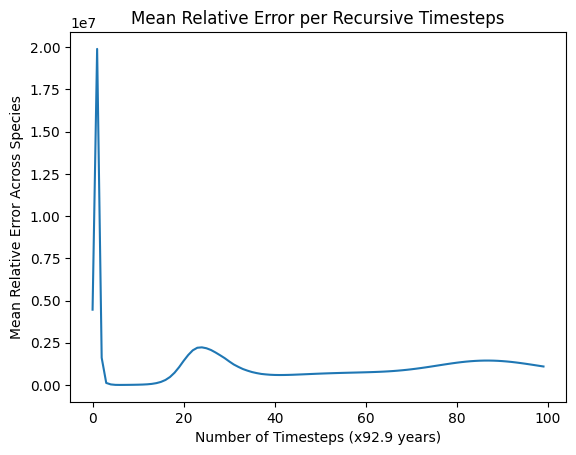

In [ ]:
plt.plot(
    np.arange(err[:200].shape[0]), err[:200].mean(dim=1).cpu().numpy(), label="Mean Relative Error"
)
plt.title("Mean Relative Error per Recursive Timesteps")

plt.xlabel("Number of Timesteps (x92.9 years)")
plt.ylabel("Mean Relative Error Across Species")
plt.show()

In [3]:
training_np, validation_np = dl.load_datasets(GeneralConfig, EMConfig.columns)
del training_np

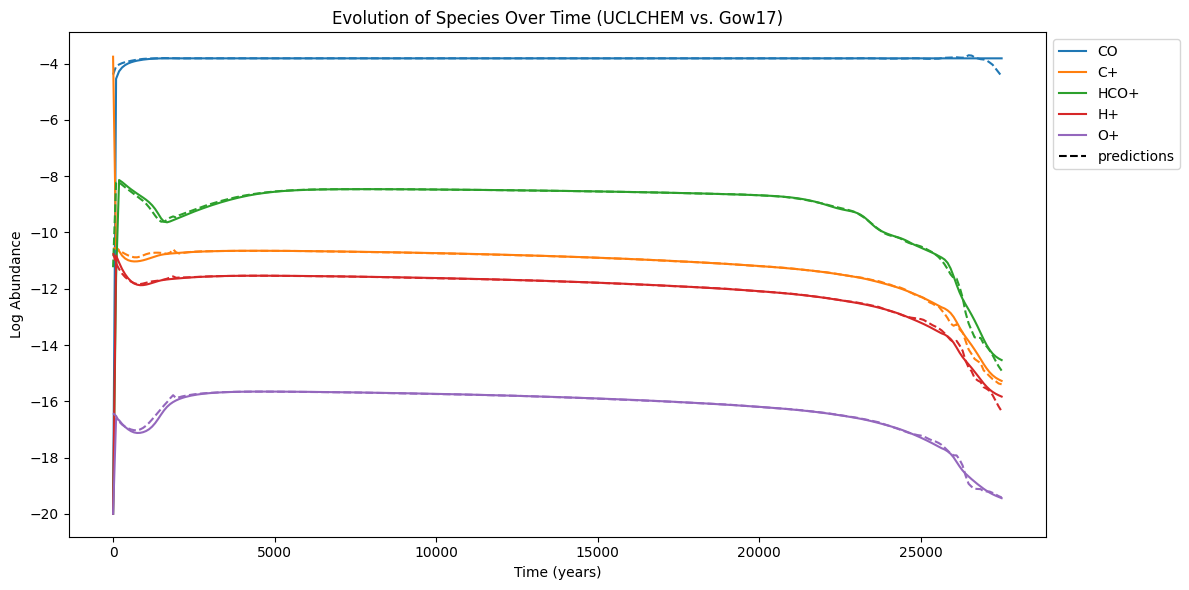

In [ ]:
model_of_interest = 5
unique_models = np.unique(validation_np[:, 1])
species_of_interest = [
    "CO",
    "C+",
    "HCO+",
    "H+",
    "O+",
]  # ["H", "H2", "O", "C", "N", "CL", "E_minus", "CO", "MG", "#C", "H2O", "SI", "C+"]

df_model = pd.DataFrame(
    validation_np[validation_np[:, 1] == unique_models[model_of_interest]],
    columns=GeneralConfig.metadata
    + GeneralConfig.phys
    + GeneralConfig.species,
)

z = df_model[GeneralConfig.phys].to_numpy()
processing.physical_parameter_scaling(z)
df_model[GeneralConfig.phys] = z

results = (
    inference.emulate(
        df_model[GeneralConfig.phys].to_numpy()[None, :, :],
        df_model[GeneralConfig.species].to_numpy()[:1],
    )
    .cpu()
    .numpy()
)
df_results = pd.DataFrame(results.squeeze(0), columns=GeneralConfig.species)

fig, ax = plt.subplots(figsize=(12, 6))

for species in species_of_interest:
    if species in df_model.columns:
        x_log_abundance = np.log10(df_model[species])
        x_log_abundance = np.maximum(x_log_abundance, -20)
        y_log_abundance = np.log10(df_results[species])
        y_log_abundance = np.maximum(y_log_abundance, -20)

        (line_actual,) = ax.plot(df_model["Time"], x_log_abundance, label=species)
        ax.plot(
            df_model["Time"],
            y_log_abundance,
            linestyle="--",
            color=line_actual.get_color(),
        )

(dummy_line,) = ax.plot([], [], linestyle="--", color="black", label="predictions")

ax.set_xlabel("Time (years)")
ax.set_ylabel("Log Abundance")
ax.set_title("Evolution of Species Over Time (UCLCHEM vs. Neural Network)")
ax.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.show()

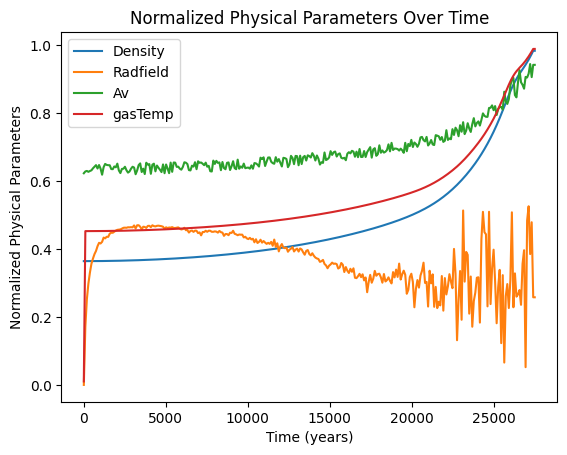

    Density  Radfield        Av   gasTemp
0  0.364587  0.000000  0.623373  0.010353
1  0.364590  0.171274  0.628692  0.452960
2  0.364597  0.252428  0.630235  0.452965
3  0.364608  0.298512  0.627586  0.452975
4  0.364624  0.330830  0.630074  0.452987


In [ ]:
for column in GeneralConfig.phys:
    plt.plot(df_model["Time"], df_model[column], label=column)

plt.title("Normalized Physical Parameters Over Time")
plt.xlabel("Time (years)")
plt.ylabel("Normalized Physical Parameters")
plt.legend()
plt.show()

print(df_model[GeneralConfig.phys].head())